In [8]:
import nltk
import numpy as np
import re
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
from tqdm import tqdm
from collections import Counter
import re
import heapq
import tensorflow as tf
import pickle as p

from transformers import XLNetTokenizer, XLNetModel,XLNetModel
import pandas as pd
import torch
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [12]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\603766\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [16]:
pd.set_option('display.expand_frame_repr', False)

df=pd.read_csv('../data/metadata.csv')



In [ ]:
df["publish_year"] = list(map(lambda date: int(date[:4]) if type(date)==str else 0,df['publish_time']))
df = df[df["publish_year"]>=2000].reset_index(drop=True)
abstracts=df['abstract']

ngram_count = 1
num_words_to_keep = 20000
num_ngrams_to_keep = 15000

In [17]:
df.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_full_text,full_text_file,url,publish_year
0,vho70jcx,f056da9c64fbf00a4645ae326e8a4339d015d155,biorxiv,SIANN: Strain Identification by Alignment to N...,10.1101/001727,NaN,NaN,biorxiv,Next-generation sequencing is increasingly bei...,2014-01-10,Samuel Minot; Stephen D Turner; Krista L Ternu...,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/001727,2014
1,i9tbix2v,daf32e013d325a6feb80e83d15aabc64a48fae33,biorxiv,Spatial epidemiology of networked metapopulati...,10.1101/003889,NaN,NaN,biorxiv,An emerging disease is one infectious epidemic...,2014-06-04,Lin WANG; Xiang Li,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/003889,2014
2,62gfisc6,f33c6d94b0efaa198f8f3f20e644625fa3fe10d2,biorxiv,Sequencing of the human IG light chain loci fr...,10.1101/006866,NaN,NaN,biorxiv,Germline variation at immunoglobulin gene (IG)...,2014-07-03,Corey T Watson; Karyn Meltz Steinberg; Tina A ...,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/006866,2014
3,058r9486,4da8a87e614373d56070ed272487451266dce919,biorxiv,Bayesian mixture analysis for metagenomic comm...,10.1101/007476,NaN,NaN,biorxiv,Deep sequencing of clinical samples is now an ...,2014-07-25,Sofia Morfopoulou; Vincent Plagnol,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/007476,2014
4,wich35l7,eccef80cfbe078235df22398f195d5db462d8000,biorxiv,Mapping a viral phylogeny onto outbreak trees ...,10.1101/010389,NaN,NaN,biorxiv,Developing methods to reconstruct transmission...,2014-11-11,Stephen P Velsko; Jonathan E Allen,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/010389,2014


In [ ]:
df.shape

In [52]:
from sklearn.decomposition import NMF, LatentDirichletAllocation
def string_cleaner(text):
    # Clean the documents
    stop = set(stopwords.words('english') + stopwords.words('spanish') + stopwords.words('french'))
    exclude = set(string.punctuation)
    wordnet_lemmatizer = WordNetLemmatizer()
    start_strip_word = ['abstract', 'background', 'summary', 'objective']
    text = str(text).lower() # downcase
    for word in start_strip_word:
        if text.startswith(word):
            text = text[len(word):]
    tokens = nltk.tokenize.word_tokenize(text) # split string into words (tokens)
    tokens = [wordnet_lemmatizer.lemmatize(t) for t in tokens] # put words into base form
    tokens = [t for t in tokens if t not in stop] # remove stopwords
    tokens = [t for t in tokens if len(t) > 2] # remove short words, they're probably not useful
    return tokens


text_tokens = [string_cleaner(abstract) for abstract in abstracts]

In [53]:
tokens_joined=["".join(tokens) for tokens in text_tokens]

In [54]:
from sklearn.feature_extraction.text import CountVectorizer
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english',max_features=num_words_to_keep,ngram_range=(2,2))
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(tokens_joined)


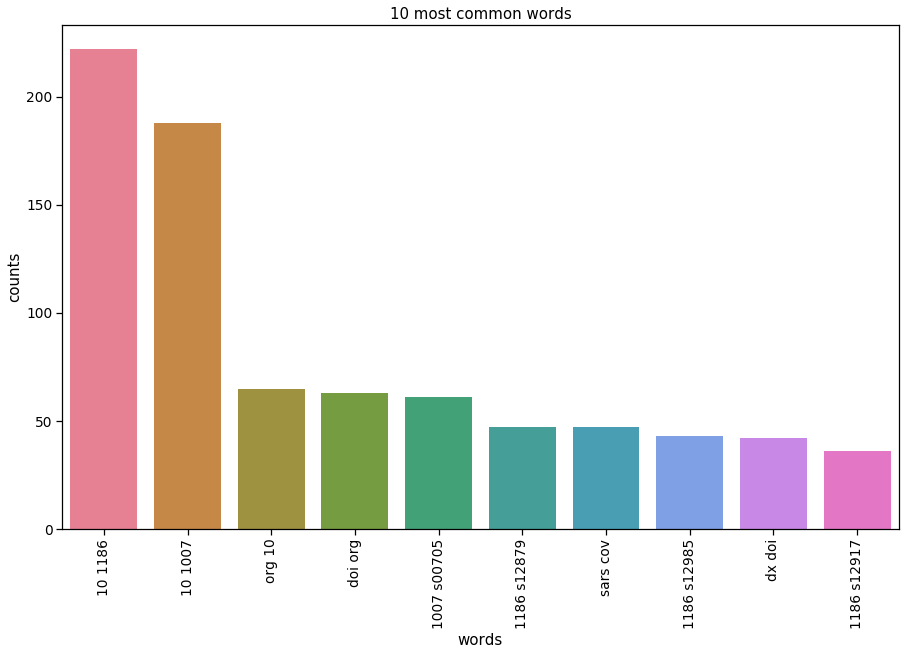

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
def plot_10_most_common_words(count_data, count_vectorizer):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts += t.toarray()[0]

    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x: x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words))

    plt.figure(2, figsize=(15, 15 / 1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90)
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(", ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

In [56]:
number_topics = 12
number_words = 10



# Run LDA
lda = LatentDirichletAllocation(n_components=number_topics, max_iter=100,random_state=0,n_jobs=-1)
lda.fit(count_data)
lda_data = pd.DataFrame(lda.transform(count_data), columns = ["Topic_"+str(i) for i in range(number_topics)])
agg_df = pd.concat([df,lda_data], axis=1)

aggregations = {"Topic_"+str(i):'mean' for i in range(number_topics)}
aggregations["url"] = "count"
agg_df = agg_df.groupby("publish_year").agg(aggregations)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
vietnam 1203, timereversetranscription pcrrt, stepreal timert, oc43 δns12, ch lhb, newcoronavirussars cov, ch lsd, hydroxy methyl, california 04, brisbane 59

Topic #1:
sars cov, pcr esi, cov 2sars, basedreal timert, 1186 s12917, s12879 018, s12917 018, 1186 s12879, 13 263, s00705 018

Topic #2:
org 10, doi org, dx doi, 10 7554, 7554 elife, 10 1038, 19causedsars cov, cov cpsr, 6b 6b, specificicam grabbingnonintegrindc

Topic #3:
10 1007, 1007 s00705, covsars cov, 1186 s12917, s12985 018, 1186 s12985, αifn βifn, severeacuterespiratorysyndromecoronavirussars cov, cov 2infection, s00705 017

Topic #4:
10 1186, 19sars cov, ahrv bhrv, assistedlaserdesorption ionizationtime, 1186 s12879, 100 000, 2sars cov, 19causedsevereacuterespiratorysyndromecoronavirussars cov, grabbingnon integrindc, s12879 015

Topic #5:
10 1007, 1007 s11262, ch ldl, severeacuterespiratorysyndrome associatedcoronavirussars, dnaboostedi ps, s00705 015, esi ms, 2010 jt, ch 2010, γil 2tnf


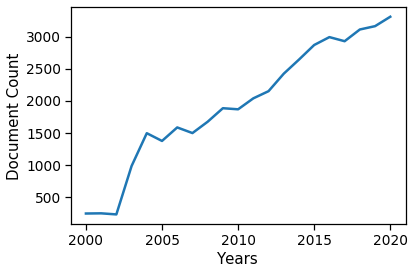

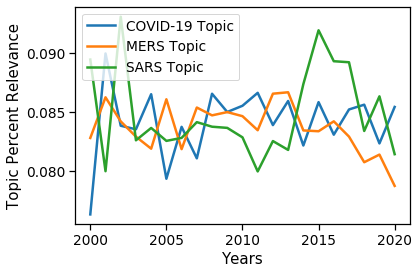

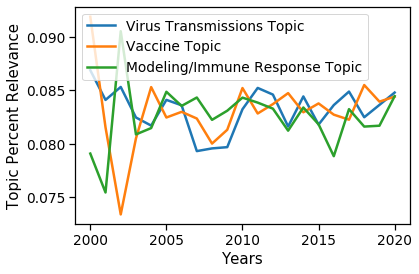

In [57]:
plt.figure()
plt.plot(agg_df["url"])
plt.xlabel('Years')
plt.ylabel('Document Count')


plt.figure()
plt.plot(agg_df["Topic_3"], label="COVID-19 Topic")
plt.plot(agg_df["Topic_5"], label="MERS Topic")
plt.plot(agg_df["Topic_6"], label="SARS Topic")
plt.xlabel('Years')
plt.ylabel('Topic Percent Relevance')
plt.legend(loc='upper left')

plt.figure()
plt.plot(agg_df["Topic_2"], label="Virus Transmissions Topic")
plt.plot(agg_df["Topic_4"], label="Vaccine Topic")
plt.plot(agg_df["Topic_0"], label="Modeling/Immune Response Topic")
plt.xlabel('Years')
plt.ylabel('Topic Percent Relevance')
plt.legend(loc='upper left')

In [58]:
from pyLDAvis import sklearn as sklearn_lda
import pickle
import pyLDAvis
import os

LDAvis_data_filepath = os.path.join('./ldavis_prepared_' + str(number_topics))
LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)


C:\Users\603766\AppData\Local\Continuum\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [59]:
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
3      0.081593 -0.191236       1        1  9.801900
6     -0.202402 -0.065086       2        1  9.419805
5      0.055560 -0.025805       3        1  8.660739
2      0.019929  0.067408       4        1  8.229399
0      0.013824  0.020099       5        1  8.198383
10     0.030602  0.048290       6        1  8.177081
7      0.007671  0.047566       7        1  8.117692
4     -0.043263 -0.000962       8        1  8.037290
9      0.015714  0.042415       9        1  8.023227
1      0.030337 -0.001201      10        1  7.991474
8     -0.002434  0.030931      11        1  7.748728
11    -0.007129  0.027582      12        1  7.594282, topic_info=      Category        Freq                                               Term       Total  loglift  logprob
192    Default  131.000000                                            10 1186  131.000000  30.0000  30.0000

In [ ]:
pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_' + str(number_topics) + '.html')